## Capítulo 10 - Classificação 

A classificação é um método de aprendizagem supervisionada (supervised learning) para atribuir um rótulo a uma amostra com base nos atributos. A aprendizagem supervisionada implica que temos rótulos para classificação ou números para regressão, os quais o algoritmo deve aprender.

No sklearn, criamos uma instância de modelo e chamamos aí o método ".fit" com os dados e rótulos de treinamento. Podemos então chamar o método ".predict" (ou os métodos ".predict_proba" ou ".predict_log_proba") com o modelo após a adequação. Para avaliar o modelo, usamos ".score" com os dados e rótulos de teste.

Em geral, o maior desafio é organizar os dados em um formato apropriado para o sklearn. Os dados(X) devem estar em um array (m por n) numpy(ou em um DataFrame pandas) com m linhas de dados de amostras, cada uma com n atributos (colunas). O rótulo (y) é um vetor (ou uma séria Pandas) de tamanho m com um valor (classe) para cada amostra.

O método ".score" devolve a precisão(accuracy) média que, por si só, poderia não ser suficiente para avaliar um classificador. Apresentaremos também outras métricas para avaliação.

###### Os métodos genéricos que os modelos do sklearn implementam são: 

* fit(X, y[,sample_weight]) => Faz a adequação de um modelo.

* predict(X) => Faz a predição de classes.

* predict_log_proba(X) => Faz a predição do logaritmo das probabilidades.

* predict_proba(X) => Faz a predição de probabilidades.

* score(X, y[,sample_weight]) => Obtém a precisão (accuracy).

### Regressão Logística

A regressão logística estima probabilidades usando uma função logística (Tome cuidado: apesar de ter regressão no nome, ela é usada para classificação). Esse tem sido o modelo de classificação padrão para a maioria das ciências.

###### A seguir, apresentamos algumas das características que incluíremos em cada modelo:

* Eficiência na execução => Pode usar n_jobs se não estiver usando o solucionador "liblinear".

* Pré-processamento dos dados => Se solver estiver definido com 'sag' ou 'saga', padronize para que a convergência funcione. É capaz de lidar com entrada esparsas.

* Para evitar uma superadequação => O parâmetro C controla a regularização. (Valores menores de C significam mais regularização, enquanto valores maiores significam menos). É possível especificar penalty com 'l1' ou 'l2' (o default).

* Interpretação dos resultados => O atributo ".coef" do modelo após a adequação  mostra os coefecientes da função de decisão. Uma mudança de X em uma unidade modifica o log odds ratio. (logaritmo da razão de chances) de acordo com o coeficiente. O atributo ".intercept_" é o inverso dos log odds da condição de base.

Eis um exemplo de uso desse modelo:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.experimental import (
    enable_iterative_imputer,
)
from sklearn import (
    ensemble,
    impute,
    model_selection,    
    preprocessing,
    tree,
)

In [2]:
# Caminho em Pasta
path = "datasets/titanic/titanic3.xls"
df = pd.read_excel(path)
orig_df = df

In [3]:
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()

    fitted = fi.fit_transform(X_train[num_cols])
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    if std_cols:
        std = preprocessing.StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

ti_df = tweak_titanic(df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])


In [4]:
from sklearn.linear_model import (LogisticRegression)

lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [5]:
lr.score(X_test, y_test)

0.8015267175572519

In [6]:
lr.predict(X.iloc[[0]])

array([0])

In [7]:
lr.predict_proba(X.iloc[[0]])

array([[0.89757798, 0.10242202]])

In [8]:
lr.predict_log_proba(X.iloc[[0]])

array([[-0.10805527, -2.27865357]])

In [9]:
lr.decision_function(X.iloc[[0]])

array([-2.1705983])

###### Parâmetros da instância:
    
-> penalty='l2' => Norma da penalização, 'l1' ou 'l2'.

-> dual=False => Usa formulação dual (somente com 'l2' e 'liblinear').

-> C=1.0 => Ponto flutuante positivo. Inverso da força de regularização. Um valor menor significa uma regularização mais forte.

-> fit_intercept=True => Adiciona bias (viés) à função de decisão.

-> intercept_scaling=1 => Se fit_intercept e 'liblinear', escala o intercepto.

-> max_iter=100 => Número máximo de iterações.

-> multi_class='ovr' => Usa one-versus-rest (um contra todos) para cada classe ou, para 'multinomial', treina uma classe.

-> class_weight=None => Dicionário ou 'balanced'.

-> solver='liblinear' => 'liblinear' é apropriado para poucos dados, 'newton-cg', 'sag', 'saga' e 'lbfgs' devem ser usados para dados multiclasse. 'liblinear'  e 'saga' só funcionam com penalidade 'l1'. Os demais funcionam com 'l2'.

-> tol=0.0001 => Tolerância para parada.

-> verbose=0 => Verboso (se int diferente de zero).

-> warm_start=False => Se for "True", lembra a adequação anterior.

-> njobs=1 => Número de CPUs a se usado, -1 são todas as CPUs. Funciona somente com multi_class='ovr' e solver diferente de 'liblinear'.

###### Atributos após a adequação:
    
-> coef_ => Coeficientes da função de decisão.

-> intercept_ => Intercepto de decisão.

-> n_iter_ => Número de iterações.

O intercepto é o log odds (logaritmo das chances) da condição de base. Podemos convertê-lo de volta em uma precisão percentual (proporção):

In [10]:
lr.intercept_

array([1.284538])

Usando a função logit inversa, vemos que o valor de base oara a sobrevivência é de 78%:

In [11]:
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

In [12]:
inv_logit(lr.intercept_)

array([0.78322125])

É possível inspecionar os coeficientes. O logit inverso dos coeficientes nos dá a proporção dos casos positivos. Nesse caso, se fare (preço da passagem) for maior, há mais chances de sobrevivência. Se sex(sexo) for male (masculino), haverá menos chances de sobrevivência.

In [13]:
cols = X.columns
for col, val in sorted(
    zip(cols, lr.coef_[0]),
    key=lambda x: x[1],
    reverse=True,
):
    print(
        f"{col:10}{val:10.3f} {inv_logit(val):10.3f}"
    )

fare           0.102      0.525
parch         -0.071      0.482
sibsp         -0.272      0.432
age           -0.294      0.427
embarked_Q    -0.544      0.367
embarked_S    -0.549      0.366
pclass        -0.736      0.324
sex_male      -2.435      0.081


O Yellowbrick também permite visualizar os coeficientes. Esse visualizador tem um parâmetro "relative=True" que faz com que o maior valor seja 100 (ou -100), e os demais sejam porcentagens desse valor.

/home/luciano/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/luciano/anaconda3/lib/python3.9/site-packages/yellowbrick/model_selection/importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


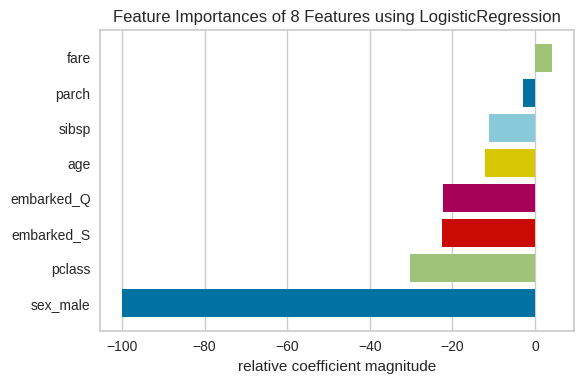

In [14]:
from yellowbrick.model_selection import (
    FeatureImportances,
)

fig, ax = plt.subplots(figsize=(6, 4))
fig_viz = FeatureImportances(lr)
fig_viz.fit(X, y)
fig_viz.poof()
fig.savefig("images/mlpr_1001.png", dpi=300)

Naive Bayes

O Naive Bayes é um classificador probalístico que pressupõe uma independência entre os atributos dos dados. É popular para aplicações de classificação de textos, por exemplo, para identificação de spams. Uma vantagem desse modelo é que, por supor uma independência entre os atributos, ele é capaz de fazer o treinamento de um modelo com um número pequeno de amostras. (Uma desvantagem é que o modelo não conseguirá capturar as interações entre os atributos). Esse modelo simples também pode trabalhar com dados que tenham vários atributos. Desse modo, serve como um bom modelo de base.

Há três classes no sklearn: "GaussianNB", "MultinomialNB" e "BernoulliNB". A primeira supõe uma distribuição gaussiana (atributos contínuos com uma distribuição normal), a segunda é para contadores de ocorrência discretos, e a terceira, para atributos booleanos discretos.

###### Esse modelo tem as seguintes propriedades:

* Eficiência na execução => Treinamento O(Nd), em que N é o número de exemplos para treinamento, e d é a dimensionalidade. Testes O(cd), em que "c" é o número de classes.

* Pré-processamento dos dados => É pressuposto que os dados são independentes. O desempenho deverá ser melhor após a remoção de colunas colineares. Para dados numéricos contínuos, talvez seja uma boa ideia separar os dados em bins. A classe gaussiana implica uma distribuição normal, e pode ser necessário ter de transformar os dados a fim de convertê-los em uma distribuição desse tipo.

* Para evitar uma superadequação => Exibe alto bias e baixa variância (os ensembles não reduzirão a variância).

* Interpretação dos resultados => A porcentagem é a probabilidade de uma amostra pertencer a uma classe com base em priors (conhecimento prévio).

Eis um exemplo que utiliza esse modelo:

In [15]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [16]:
nb.score(X_test, y_test)

0.7557251908396947

In [17]:
nb.predict(X.iloc[[0]])

array([0])

In [18]:
nb.predict_proba(X.iloc[[0]])

array([[0.95955327, 0.04044673]])

In [19]:
nb.predict_log_proba(X.iloc[[0]])

array([[-0.04128744, -3.20776957]])

###### Parâmetros da instância

* priors=None => Probabilidades prévias (prior) das classes.

* var_smoothing=1e-9 => Adicionado à variância para cálculos estáveis.

###### Atributos após a adequação:
    
-> class_prior_ => Probabilidades das classes.

-> class_count_ => Contadores de classes.

-> theta_ => Média de cada coluna por classe.

-> sigma_ => Variância de cada coluna por classe.

-> epsilon_ => Valor a ser somado para cada variância.

### Máquina de vetores suporte

Uma SVM (Support Vector Machine, ou Máquina de Vetores Suporte) é um algoritmo que tenta fazer a adequação de uma linha (ou plano ou hiperplano) entre diferentes classes de modo a maximizar a distância da linha até os pontos das classes. Dessa maneira, ela tenta encontrar uma separação robusta entre as classes. Os vetores suporte São os pontos da fronteira do hiperplano divisor.

Em geral, a SVM tem um bom desempenho e oferece suporte para espaços lineares e não lineares usando um truque de kernel. O truque de kernel é a ideia de que podemos criar uma fronteira de decisão em uma nova dimensão minimizando uma fórmula que seja mais fácil de calcular, em comparação a realmente mapear os pontos para a nova dimensão. O kernel default é o "Real Basis Function", ou Função de Base Radial ('rbf'), controlado pelo padrão 'gamma', o qual é capaz de mapear um espaço de entrada em um espaço com mais dimensões.

###### As SVMs tem as seguintes propriedades:

-> Eficiência na execução => A implementação do scikit-learn, portanto pode ser difícil escalar para tamanhos maiores. Usar um kernel linear ou o modelo LinearSVC pode melhorar o desempenho da execução, talvez à custa da precisão.Aumentar o valor do parâmetro "cache_size" pode reduzir a ordem.

-> Pré-processamento dos dados => O algoritmo não é invariante à escala. Padronizar os dados pe extremamente recomendável.

-> Para evitar uma superadequação => O parâmetro c (parâmetro de penalidade) controla a regularização. Um valor menor permite ter uma margem menor no hiperplano. Um valor maior para "gamma" tenderá a uma superadequação nos dados de treinamento. O modelo "LinearSVC" aceita parâmetros "loss" e "penalty" para regularização.

-> Interpretação dos resultados => Inspecione ".support_vectors_", embora possam ser difíceis de explicar. Com kernels lineares, poderá inspecionar ".coef_".

Eis um exemplo que usa a implementação de SVM do scikit-learn:

In [20]:
from sklearn.svm import SVC
svc = SVC(random_state=42, probability=True)
svc.fit(X_train, y_train)

SVC(probability=True, random_state=42)

Para obter probabilidades, utilize "probability=True", que deixará a adequação do modelo mais lenta.

Isso é parecido com um percepton, mas encontrará a margem máxima. Se os dados não forem linearmente separáveis, ele minimizará o erro. Como alternativa, um kernel diferente pode ser usado.

###### Parâmetros da instância:

-> C=1.0 => Parâmetro de penalidade. Quanto menor o valor, mais estreita será a fronteira de decisão (mais superadequação).

-> cache_size=200 => Tamanho do cache (MB). Aumentar esse valor pode melhorar o tempo de treinamento em conjuntos grandes de dados.

-> class_weight=None => Dicionário ou "balanced". Use um dicionário para definir C para cada classe.

-> coef=0.0 => termo independente para kernels polimonial e sigmoide.

-> decision_function_shape='ovr' => Use one-versus-rest (um contra todos)('ovr') ou one-versus-one (um contra um).

-> degree=3 => Grau para kernel polimonial.

-> gamma='auto' => Coeficiente do kernel. Pode ser um número, "scale" (default em 0,22, 1 / (num atributos * X.std())) ou "auto" (default anterior, 1 / num atributos). Um valor menor resulta na superadequação dos dados de treinamento.

-> kernel='rbf' => Tipo de kernel: "linear", "poly", "rbf", (default), "sigmoid", "precomputed" ou uma função.
    
-> max_iter=-1 => Número máximo de iterações para o solucionador (solver), -1 indica que não há limites.

-> probability=False => Ativa a estimação de probabilidades. Deixa o treinamento mais lento.

-> random_solver=None => Semente(seed) aleatória.

-> shrinking=True => Usa a heurística de shrinking (encolhimento).

-> tol=0.001 => Tolerância para parada.

-> verbose=False => Verbosidade.


###### Atributos após a adequação

-> support_ => Índices dos vetores de suporte.

-> support_vectors_ => Vetores suporte.

-> n_support_vectors_ => Número de vetores suporte por classe.

-> coef_ => Coeficientes para kernel (linear).

### K vizinhos mais próximos

O algoritmo KNN (K-Nearest Neighbor, ou K Vizinhos Mais Próximos)faz a classificação com base na distância até algumas amostras (k) de treinamento. A família de algoritmos é chamada de aprendizado baseado em instâncias (instance-based learning), pois não há parâmetros para aprender. O modelo pressupõe que a distância é suficiente para fazer uma inferência; afora isso, nenhuma presuposição é feita sobre os dados subjacentes ou suas distribuições.

A parte complicada é selecionar o valor apropriado de K. Além disso, a maldição da dimensionalidade pode atrapalhar as métricas de distância, pois haverá pouca diferença entre os vizinhos mais próximos e mais distantes no caso de mais dimensões.

Os modelos que usam vizinhos mais próximos têm as seguintes propriedades:

###### Efeciência na execução

Treinamento O(1), mas precisa armazenar dados. Testes O(Nd), em que N é o número de exemplos de treinamento e d é a dimensionalidade.

###### Pré-processamento dos dados

Sim cálculos baseados em distância têm melhor desempenho se houver padronização.

###### Para evitar uma superadequação

Eleva n_neighbors. Mude p para métrica L1 ou L2.

###### Interpretação dos resultados

Interpreta os k vizinhos mais próximos para a amostra (usando o método ".kneighbors"). Esses vizinhos explicarão os resultados.

Exemplo do uso do modelo

In [21]:
from sklearn.neighbors import (
    KNeighborsClassifier,
)

knc = KNeighborsClassifier()
knc.fit(X_train, y_train)

KNeighborsClassifier()

In [22]:
knc.score(X_test, y_test)

0.7659033078880407

In [23]:
knc.predict(X.iloc[[0]])

array([0])

In [24]:
knc.predict_proba(X.iloc[[0]])

array([[0.8, 0.2]])

###### Atributos:
    
-> algorithm='auto' => Pode ser 'brute', 'ball-tree' ou 'kd_tree'.

-> leaf_size=30 => Usado para algoritmos baseados em árvore.

-> metric='minkowski' => Métrica de distância.

-> metric_params=None => Dicionário de parâmetros para função de métrica personalizada.

-> n_jobs=1 => Número de CPUs.

-> n_neighbors=5 => Número de vizinhos.

-> p=2 => Parâmetro de potência de Minkowski:1 = manhattan (L1); 2 = euclidiana(L2).
    
-> weights='uniform' => Pode ser 'distance', caso em que pontos mais próximos terão mais influência.

As métricas de de distância incluem: 'euclidean', 'manhattan', 'chebyshev', 'minkowski', 'wminkowski', 'seuclidean', 'mahalanobis', 'haversine', 'hamming', 'canberra', 'braycurtis', 'jaccard', 'matching', 'dice', 'rogerstanimoto', 'russellrao', 'sokalmichener', 'sokalsneath' ou um callable (definido pelo usuário).

### Árvore de decisão

Uma árvore de decisão é como ir a um médico que faz uma série de perguntas a fim de determinar a causa de seus sintomas. Podemos usar um processo para criar uma árvore de decisão e ter uma série de perguntas para prever uma classe alvo. As vantagens desse modelo incluem suporte para dados não numéricos (em algumas implementações), pouca preparação dos dados (não há necessidade de escalar), suporte para lidar com relacionamentos não lineares, a importância dos atributos é revelada e é fácil de explicar.

O algoritmo padrão usado para a criação se chama CART (classification And Regression Tree, Árvore de Classificação e Regressão). Ele usa a impureza de Gini ou medida de índices para tomada de decisões. Isso é feito percorrendo os atributos em um laço e encontrando o valor que forneça a menor probabilidade de erro de classificação.

As árvores de decisão têm as seguintes propriedades: 

###### Eficiência na execução

Para a criação, percorre cada um dos m atributos e ordena todas as n amostras, O(mn log n).Para predição, percorrerá a árvore, O(altura).

###### Pré-processamento dos dados

Não é ncessário escalar. É preciso se livrar dos valores ausentes e convertê-los em dados numéricos.

###### Para evitar uma superadequação

Defina "max_depth" com um número menor, e aumente "min_impurity_decrease".

###### Interpretação dos resultados

É possível percorrer a árvore de opções. Por haver passos, uma árvore é ruim para lidar com relacionamentos lineares (uma pequena mudança em um número pode levar a um caminho diferente). 

A árvore também é extremamente dependente dos dados de treinamento. Uma pequena mudança pode modificar a árvore toda.

Exemplo que utiliza a biblioteca scikit-learn

In [25]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(
    random_state=42, max_depth=3
)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [26]:
dt.score(X_test, y_test)

0.8142493638676844

In [27]:
dt.predict(X.iloc[[0]])

array([0])

In [28]:
dt.predict_proba(X.iloc[[0]])

array([[0.87954545, 0.12045455]])

In [29]:
dt.predict_log_proba(X.iloc[[0]])

array([[-0.12835003, -2.11648281]])

###### Parâmetros da instância:

-> Class_weight=None => Pesos das classes em um dicionário. 'balanced' definirá valores na proporção inversa das frequências das classes. O default é 1 para cada classe. Para várias classes, é necessário ter uma lista de dicionários, OVR (one-versus-rest, ou um contra todos) para cada classe.

-> criterion='gini' => Função de separação, 'gini' ou 'entropy'.

-> max_depth=None => Profundidade da árvore. O default será construir a árvore até que as folhas contenham menos que "min_samples_split".

-> max_features=None => Número de atributos a serem analisados para separação. O default são todos.

-> max_leaf_nodes=None => Limita o número de folhas. O default é sem limites.

-> min_impurity_decrease=0.0 => Separa um nó se a separação diminuir a impureza, por um valor maior ou igual a este.

-> min_impurity_split=None => Obsoleto.

-> min_samples_leaf=1 => Número mínimo de amostras em cada folha.

-> min_samples_split=2 => Número mínimo de amostras exigido para separar um nó.

-> min_weight_fraction_leaf=0.0 => Soma mínima de pesos exigida para nós do tipo folha.

-> presort=False => Pode agilizar o treinamento com um conjunto de dados menor ou com uma profundidade restrita se definido com True.

-> random_state=None => Semente(seed) aleatória.

-> splitter='best' => Use 'random' ou 'best'.

###### Atributos após a adequação:
    
-> classes_ => Rótulos das classes.

-> feature_importances_ => Array de importância de Gini.

-> n_classes_ => Número de classes.

-> n_features_ => Número de atributos.

-> tree_ => Objeto árvore subjacentes.

###### Visualize a árvore 

In [30]:
#!pip install pydotplus

In [31]:
import pydotplus
from io import StringIO
from sklearn.tree import export_graphviz

dot_data = StringIO()
tree.export_graphviz(
    dt,
    out_file=dot_data,
    feature_names=X.columns, 
    class_names=["Died", "Survived"], 
    filled=True,
)

In [32]:
g = pydotplus.graph_from_dot_data(
    dot_data.getvalue()
)

In [33]:
g.write_png("images/mlpr_1002.png")

True

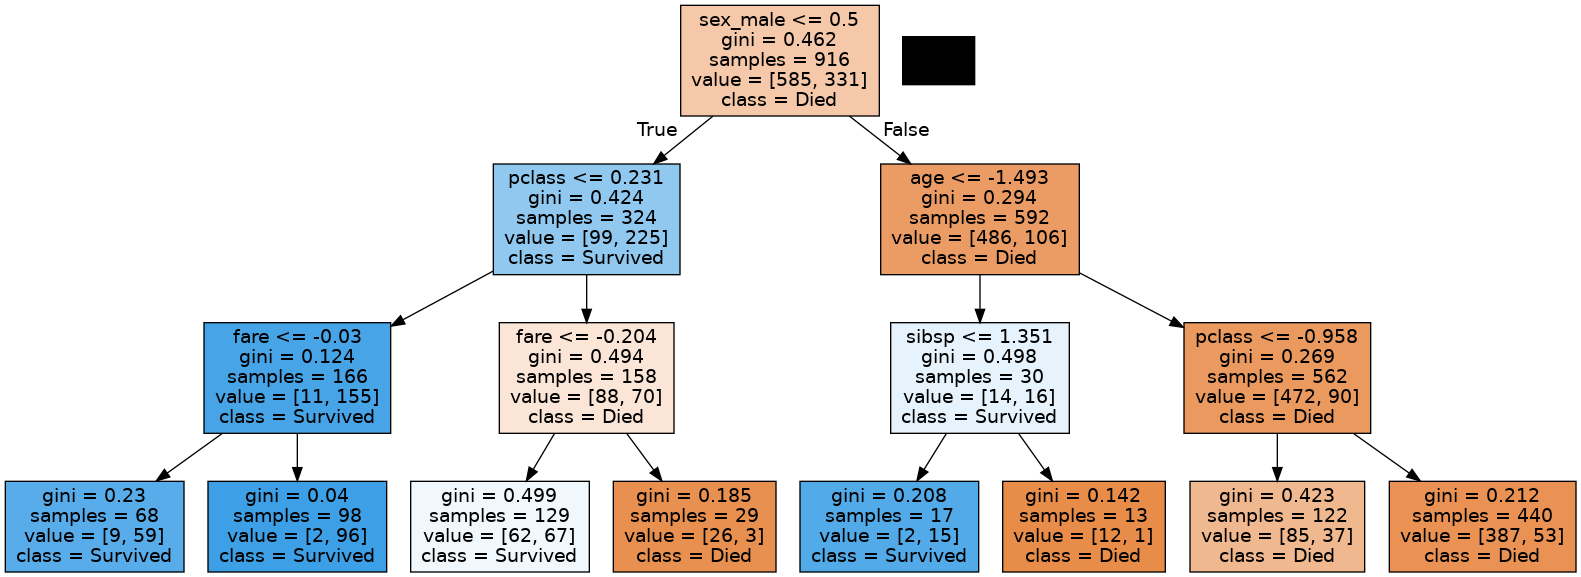

In [34]:
from IPython.display import Image
Image(g.create_png())

O pacote "dtreeviz" (https://github.com/parrt/dtreeviz) pode ajudar a compreender como a árvore de decisão funciona. Ele cria uma árvore com histograma contendo rótulos, a qual possibilita insights valiosos.

A seguir será mostrado um exemplo. No Jupyter, podemos exibir o objeto viz diretamente. Se estivermos trabalhando com um script, podemos chamar o método ".save" para criar um PDF, um SVG ou um PNG:

Importância dos atributos mostrando a importância de Gini (redução de erro usando esse atributo):

In [35]:
for col, val in sorted(
    zip(X.columns, dt.feature_importances_),
    key=lambda x: x[1], 
    reverse=True,
)[:5]:
    print(f"{col:10}{val:10.3f}")

sex_male       0.607
pclass         0.248
sibsp          0.052
fare           0.050
age            0.043


Podemos usar também o Yellowbrick para visualizar a importância dos atributos:

/home/luciano/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


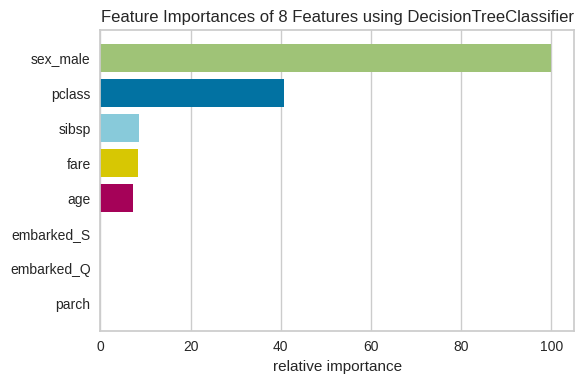

In [36]:
from yellowbrick.model_selection import (
    FeatureImportances,
)

fig, ax = plt.subplots(figsize=(6, 4))
fi_viz = FeatureImportances(dt)
fi_viz.fit(X, y)
fi_viz.poof()
fig.savefig("images/mlpr_1004.png", dpi=300)

### Floresta Aleatória

Uma floresta aleatória é um conjunto de árvores de decisão. Ela usa "bagging" para corrigir a tendência das árvores de decisão à superadequação. Ao criar várias árvores treinadas com subamostras e atributos aleatórios dos dados, a variância é reduzida.

Como o treinamento é feito em subamostras dos dados, as florestas aleatórias são capazes de avaliar o erro "OOB" e o desempenho. Podem também exibir a importância dos atributos, calculando a média da importância em todas as árvores.

A ideia das florestas aleatórias é criar uma "floresta" de árvores de decisão treinadas em diferentes colunas dos dados de treinamento. Se cada árvore tiver uma chance melhor que 50% de fazer uma classificação correta, deverá incorporar a sua predição. A floresta aleatória tem sido uma excelente ferramenta tanto para classificação como para regressão, embora, recentemente, tenha cedido espaço para as árvores com gradiente "boosting".

Ela tem as seguintes propriedades:

###### Eficiência na execução

Deve criar j árvores aleatórias. Isso pode ser feito em paralelo usando "n_jobs". A complexidade de cada árvore é de O(mn log n), em que n é o número de amostras e m é o número de atributos. Para a criação, percorre cada um dos m atributos em um laço e ordena todas as n amostras, O(mn log n). Para predição, percorre a árvore, O(altura).

###### Pré-processamento dos dados

Não é necessário

###### Para evitar uma superadequação

Adicione mais árvores (N-estimators). Use um valor menor para "max_depth".

###### Interpretação dos resultados

Tem suporte para importância de atributos, porém não há uma única árvore de decisão para percorrer. É possível inspecionar árvores únicas do conjunto.

Exemplo:

In [37]:
from sklearn.ensemble import (
    RandomForestClassifier,
)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [38]:
rf.score(X_test, y_test)

0.7837150127226463

In [39]:
rf.predict(X.iloc[[0]])

array([0])

In [40]:
rf.predict_proba(X.iloc[[0]])

array([[0.9625, 0.0375]])

In [41]:
rf.predict_log_proba(X.iloc[[0]])

array([[-0.03822121, -3.28341435]])

###### Parâmetros da instância (essas opções espelham a árvore de decisão):

-> bootstrap=True => Utiliza bootstrap ao construir as árvores.

-> class_weight=None => Pesos das classes no dicionário 'balanced' definirá valores na proporção inversa das frequências das classes. O valor default é 1 para cada classe. Para várias classes, é necessário ter uma lista de dicionários OVR para cada classe.

-> criterion='gini' => Função de separação,'gini' ou 'entropy'

-> max_depth=None => Profundidade da árvore. O default será construir a árvore até que as folhas contenham menos que "min_samples_split".

-> max_features='auto' => Número de atributos para analisar na separação. O default são todos.

-> max_leaf_nodes=None => Limita o número de folhas. O default é sem limites.

-> min_impurity_decrease=0.0 => Separa um nó se uma separação diminuir a impureza, por um valor maior ou igual a esse.

-> min_impurity_split=None => Obsoleto.

-> min_samples_leaf=1 => Número mínimo de amostras em cada folha.

-> min_samples_split=2 => Número mínimo de amostras exigido para separar um nó.

-> min_weight_fraction_leaf=0.0 => Soma mínima de pesos exigida para nós do tipo folha.

-> n_estimators=10 => Número de árvores na floresta.

-> n_jobs=1 => Número de jobs para adequação e predição.

-> oob_score=False => Informa se deve estimar "oob_score".

-> random_state=None => Semente (seed) aleatória.

-> verbose=0 => Verbosidade.

-> warm_start=False => Faz a adequação de uma nova floresta ou usa uma floresta existente.

###### Atributos após adequação

-> classes_ => Rótulos das classes.

-> feature_importances_ => Array de importância de Gini.

-> n_classes_ => Número de classes.

-> n_features_ => Número de atributos.

-> oob_score_ => Pontuação "OOB". Precisão média para cada observação não usada em árvores.

Importância dos atributos mostrando a importância de Gini (redução do erro usando esse atributo):

In [42]:
for col, val in sorted(
    zip(X.columns, rf.feature_importances_),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(f"{col:10}{val:10.3f}")

age            0.285
fare           0.262
sex_male       0.241
pclass         0.089
sibsp          0.050


Veja a função "importances" do pacote rfpimp:

In [43]:
import rfpimp

rf=RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rfpimp.importances(
    rf, X_test, y_test
).Importance

Feature
sex_male      0.160305
age           0.048346
pclass        0.043257
fare          0.012723
parch         0.005089
embarked_S    0.000000
sibsp        -0.005089
embarked_Q   -0.005089
Name: Importance, dtype: float64

### XGBoost

Embora o sklearn tenha um "GradientBoostedClassifier", é melhor usar uma implementação de terceiros que utilize o extreme "boosting". Elas tendem a fornecer melhores resultados.

O XGBoost (https://oreil.ly/WBo0g) é uma biblioteca popular, além do scikit-learn. Ele cria uma árvore fraca, e, então, "melhora" as árvores subsequentes (faz um boosting) a fim de reduzir os erros residuais. O algoritmo tenta capturar e tratar qualquer padrão nos erros, até que pareçam ser aleatórios.
    
          

###### o XGBoost tem as seguintes propriedades:

###### Eficiência na execução

O XGBoost pode executar em paralelo. Utilize a opção "n_jobs" para informar o número de CPUs. Use a GPU para ter um desempenho melhor ainda.

###### Pré-processamento dos dados

Não é necessário escalar com modelos baseados em árvore. É preciso codificar os dados de categoria.

###### Para evitar uma superadequação 

O parâmetro "early_stopping_rounds=N" pode ser definido para interromper o treinamento caso não haja melhoras após N rodadas. As regularizações L1 e L2 são controladas por "reg_alpha" e "reg_lambda", respectivamente. Números maiores são mais conservadores.

###### Interpretação dos resultados

Inclui importância de atributos.

O XGBoost tem um parâmetro extra no método ".fit". O parâmetro "early_stopping_rounds" pode ser combinado com o parâmetro "eval_set" para dizer ao XGBoost que pare de criar árvores caso a métrica de avaliação não tenha melhorado após esse número de rodadas de boosting (melhorias). 'eval_metric' também pode ser definido com um dos seguintes valores: 'rmse', 'mae', 'logloss', 'error' (default), 'auc', 'aucpr', bem como com uma função personalizada.

Exemplo do uso da biblioteca

In [44]:
import xgboost as xgb

xgb_class = xgb.XGBClassifier(random_state=42)
xgb_class.fit(
    X_train, 
    y_train, 
    early_stopping_rounds=10,
    eval_set=[(X_test, y_test)]
)

[0]	validation_0-logloss:0.57936
[1]	validation_0-logloss:0.52320
[2]	validation_0-logloss:0.49346
[3]	validation_0-logloss:0.47456
[4]	validation_0-logloss:0.46537
[5]	validation_0-logloss:0.46205
[6]	validation_0-logloss:0.46137
[7]	validation_0-logloss:0.45940
[8]	validation_0-logloss:0.46473
[9]	validation_0-logloss:0.46485
[10]	validation_0-logloss:0.46264
[11]	validation_0-logloss:0.46190
[12]	validation_0-logloss:0.45958


/home/luciano/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-logloss:0.46641
[14]	validation_0-logloss:0.46284
[15]	validation_0-logloss:0.46332
[16]	validation_0-logloss:0.45892
[17]	validation_0-logloss:0.45981
[18]	validation_0-logloss:0.46122
[19]	validation_0-logloss:0.46418
[20]	validation_0-logloss:0.46380
[21]	validation_0-logloss:0.46728
[22]	validation_0-logloss:0.47139
[23]	validation_0-logloss:0.46925
[24]	validation_0-logloss:0.47044
[25]	validation_0-logloss:0.46803
[26]	validation_0-logloss:0.47045


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [45]:
xgb_class.score(X_test, y_test)

0.7862595419847328

In [46]:
xgb_class.predict(X.iloc[[0]])

array([0])

In [47]:
xgb_class.predict_proba(X.iloc[[0]])

array([[0.9089531 , 0.09104695]], dtype=float32)

###### Parâmetros da instância:

-> max_depth=3 => Profundidade máxima.

-> learning_rate=0.1 => Taxa de aprendizagem (também chamada de eta) para boosting (entre 0 e 1). Após cada passo de boosting, (melhoria) os pesos recém-adicionados são escalados de acordo com esse fator.Quanto menor o valor, mais conservador será, mas também serão necessárias mais árvores para convergir. Na chamada a ".train", pode passar um parâmetro "learning_rates", que é uma lista de taxas em cada rodada (isto é [.1] * 100 + [.05] * 100).

-> n_estimators=100 => Número de rodadas ou árvores melhoradas.

-> silent=True => Inverso de verboso.Informa se deve exibir mensagens enquanto executa boosting.

-> objective='binary:logistic' => Tarefa de aprendizagem ou callable para classificação.

-> booster='gbtree' => Pode ser 'gbtree', 'gblinear' ou 'dart'.

-> nthread=None => Obsoleto.

-> n_jobs = 1 => Número de threads a serem usadas.

-> gamma=0 => Controla a poda (prunning). Varia de 0 a infinito. Redução de perda mínima necessária para separar mais uma folha. Quanto maior o valor de gamma, mais conservador será. Se as pontuações de treinamento e de teste divergirem, insira um número maior (em torno de 10). Se as pontuações de treinamento e teste estiverem próximas, utilize um número menor.

-> min_child_weight=1 => Valor mínimo para a soma hessiana de um filho.

-> max_delta_step=0 => Deixa as atualizações mais conservadoras. Defina com valores de 1 a 10 para classes desbalanceadas.

-> subsample=1 => Fração das amostras a serem usadas na próxima rodada.

-> colsample_bytree=1 => Fração das colunas a serem usadas por rodada.

-> colsample_bylevel=1 => Fração das colunas a serem usadas por nível.

-> colsample_bynode=1 => Fração das colunas a serem usadas por nó.

-> reg_alpha=0 => A regularização L1 (média dos pesos) incentiva a dispersão. Aumente o valor para ser mais conservador.

-> reg_lambda=1 => A regularização L2 (raiz dos quadrados dos pesos) incentiva pesos menores. Aumente o valor para ser mais conservador.

-> scale_pos_weight=1 => Razão entre peso negativo/positivo.

-> base_score=.5 => Previsão inicial.

-> seed=None => Obsoleto.

-> random_state=0 => Semente(seed) aleatória.

-> missing=None => Valor de interpretação para missing. None quer dizer "np.nan".

-> importance_type='gain' => Tipo da importância do atributo: 'gain', 'weight', 'cover', 'total_gain' ou 'total_cover'.

###### Atributos: 
    
-> coef_ => Coeficientes para learners gblinear.

-> feature_importances_ => Importância de atributos para learners gbtree.


A importância dos atributos é o ganho médio em todos os nós em que o atributo é usado:

In [48]:
for col, val in sorted(
    zip(
        X.columns, 
        xgb_class.feature_importances_
    ), 
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(f"{col:10}{val:10.3}")

sex_male       0.592
pclass         0.224
sibsp          0.065
fare          0.0324
age             0.03


O XGBoost é capaz de gerar um gráfico da importância dos atributos. Ele tem um parâmetro "importance_type". O valor default é "weight", que é o número de vezes que um atributo aparece em uma árvore. Também pode ser "gain", que mostra o ganho médio quando o atributo é usado, ou "cover", que é o número de amostras afetado por uma separação:

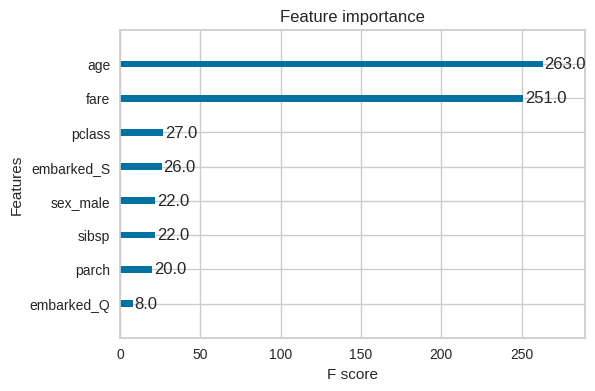

In [49]:
fig, ax = plt.subplots(figsize=(6, 4))
xgb.plot_importance(xgb_class, ax=ax)
fig.savefig("images/mlpr_1005.png", dpi=300)

Podemos gerar um gráfico com o Yellowbrick, que normaliza os valores.

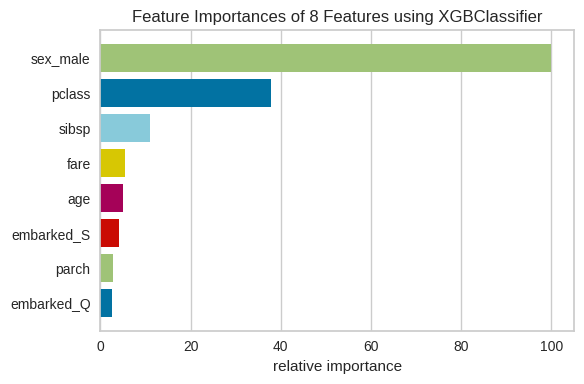

In [50]:
fix, ax = plt.subplots(figsize=(6, 4))
fi_viz = FeatureImportances(xgb_class)
fi_viz.fit(X, y)
fi_viz.poof()
fig.savefig("images/mlpr_1006.png", dpi=300)

O XGBoost fornece uma representação tanto textual como gráfica das árvores.

Exemplo de uma representação textual

In [51]:
booster = xgb_class.get_booster()
print(booster.get_dump()[0])

0:[sex_male<1] yes=1,no=2,missing=1
	1:[pclass<0.23096557] yes=3,no=4,missing=3
		3:leaf=0.508235335
		4:[fare<-0.203882411] yes=7,no=8,missing=7
			7:[fare<-0.500062585] yes=13,no=14,missing=13
				13:leaf=0.400000036
				14:[fare<-0.355997324] yes=21,no=22,missing=21
					21:[age<-0.0881974548] yes=27,no=28,missing=27
						27:leaf=-0.0315789506
						28:leaf=-0.347368419
					22:[embarked_S<1] yes=29,no=30,missing=29
						29:leaf=0.284210533
						30:leaf=0.0782608688
			8:[age<-0.456013829] yes=15,no=16,missing=15
				15:leaf=-0.461538494
				16:leaf=-0.163636371
	2:[age<-1.49289274] yes=5,no=6,missing=5
		5:[sibsp<1.35050142] yes=9,no=10,missing=9
			9:[age<-2.16597581] yes=17,no=18,missing=17
				17:leaf=0.0666666701
				18:leaf=0.450000018
			10:leaf=-0.388235331
		6:[pclass<-0.957598865] yes=11,no=12,missing=11
			11:[embarked_S<1] yes=19,no=20,missing=19
				19:[fare<0.838983417] yes=23,no=24,missing=23
					23:[age<-0.068687804] yes=31,no=32,missing=31
						31:leaf=0.200000

O valor na folha é a pontuação para a classe 1. Pode ser convertido em uma probabilidade usando a função logística. Se as decisões chegarem à folha 7, a probabilidade da classe 1 será de 53%. Essa é a pontuação de uma única árvore. Se nosso modelo tivesse 100 árvores, somaria o valor de cada folha e obteria a probabilidade com a função logística:

In [52]:
# Pontuação da folha 7 da primeira árvore
1 / (1 + np.exp(-1 * 0.1238))

0.5309105310475829

A seguir, apresentamos a versão gráfica da primeira árvore do modelo

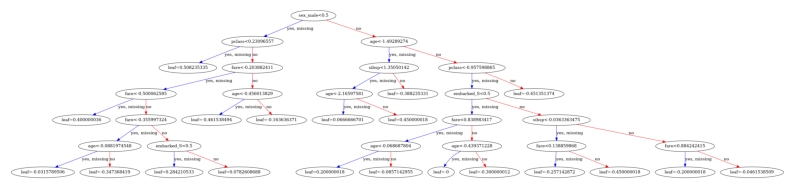

In [53]:
fig, ax = plt.subplots(figsize=(10, 4))
xgb.plot_tree(xgb_class, ax=ax, num_trees=0)
fig.savefig("images/mlpr_1007.png", dpi=300)

O pacote 'xgbfir' https://oreil.ly/kPnRv é uma biblioteca desenvolvida com base no XGBoost. Essa biblioteca fornece várias medidas relacionadas à importância dos atributos. Sua característica única é que ela fornece essas medidas sobre as colunas, e sobre pares de colunas também, de modo que será possível ver as interações. Além disso, pode obter as informações sobre interações entre trincas (três colunas).

As medidas são:
    
-> Gain => Ganho total de cada atributo ou interação entre atributos.

-> FScore => Quantidade de separações possíveis em um atributo ou interação entre atributos.

-> WFScore => Quantidade de possíveis separações em um atributo ou interação entre atributos, com pesos atribuídos de acordo com a probabilidade de as separações ocorrerem.

-> Average WFScore => WFScore dividido por FScore.

-> Average Gain => Gain dividido por FScore.

-> Expected Gain => Ganho total de cada atributo ou interação entre atributos, com pesos de acordo com a probabilidade de obter o ganho.

A interface consiste apenas de dados exportados para uma planilha, portanto, usaremos o pandas para ler os dados de volta. Eis a importância das colunas.

In [54]:
#!pip install xgbfir

In [55]:
import xgbfir
xgbfir.saveXgbFI(
    xgb_class,
    feature_names=X.columns,
    OutputXlsxFile="fir.xlsx",
)
pd.read_excel("fir.xlsx").head(3).T

,0,1,2
Interaction,sex_male,fare,age
Gain,506.228703,316.037931,307.081977
FScore,22,251,263
wFScore,18.192209,56.35466,48.170315
Average wFScore,0.826919,0.224521,0.183157
Average Gain,23.010396,1.259115,1.167612
Expected Gain,505.60392,78.059065,70.435741
Gain Rank,1,2,3
FScore Rank,5,2,1
wFScore Rank,3,1,2


A partir dessa tabela, vemos que 'sex_male' tem uma posição elevada quanto ao ganho(gain), WFScore médio(average WfScore), ganho médio (average gain) e ganho esperado (expected gain), enquanto fare (preço da passagem) se destaca quanto a FScore e WFScore. 

Vamos analisar os pares para ver as interações entre colunas:

In [56]:
pd.read_excel(
    "fir.xlsx",
    sheet_name="Interaction Depth 1",
).head(2).T

,0,1
Interaction,pclass|sex_male,age|sex_male
Gain,730.831164,497.137521
FScore,15,16
wFScore,5.610365,7.375117
Average wFScore,0.374024,0.460945
Average Gain,48.722078,31.071095
Expected Gain,267.220627,317.313031
Gain Rank,1,2
FScore Rank,11,9
wFScore Rank,6,5


Nessa caso, vemos que as duas principais interações envolvem a coluna sex_male em combinação com 'pclasse e age'. Se pudesse criar apenas um modelo com dois atributos, provavelmente iria querer escolher pclass e sex_male.

Por fim, vamos observar as trincas:

In [57]:
pd.read_excel(
    "fir.xlsx", 
    sheet_name="Interaction Depth 2",
).head(1).T

,0
Interaction,fare|pclass|sex_male
Gain,1146.35839
FScore,23
wFScore,4.455621
Average wFScore,0.193723
Average Gain,49.841669
Expected Gain,208.829083
Gain Rank,1
FScore Rank,7
wFScore Rank,7


A saída mostra apenas a primeira trica por causa da limitação no espaço, mas a planilha inclui várias outras trincas:

In [58]:
pd.read_excel(
    "fir.xlsx",
    sheet_name="Interaction Depth 2",
)[["Interaction", "Gain"]].head()

,Interaction,Gain
0,fare|pclass|sex_male,1146.358390
1,age|sex_male|sibsp,527.426927
2,age|pclass|sex_male,512.667923
3,age|fare|pclass,430.225818
4,fare|fare|pclass,369.174055


### Gradient Boosted com LightGBM

O LightGBM é uma implementação da Microsoft. Ele utiliza um método de amostragem para lidar com valores contínuos. Isso permite uma criação mais rápida das árvores (em comparação com, por exemplo, XGBoost), além de reduzir o uso de memória.

O LightGBM também cria árvores em profundidade antes (por folhas, em vez de níveis). Por causa disso, em vez de usar 'max_depth' para controlar a superadequação, utilize 'num_leaves' (esse valor é <2 ^ (max_depth)).

Esse modelo tem as seguintes propriedades:

###### Eficiência na execução

Consegue tirar proveito de várias CPUs. Se usar 'binning', pode ser 15 vezes mais rápido que o XGBoost.

###### Pré-processamento dis dados

Tem algum suporte para codificação de colunas de categorias como inteiros (ou tipo 'Categorical' do pandas), mas o AUC parece ser o pior em comparação com a codificação 'one-hot'.

###### Para evitar uma superadequação

Reduza 'num_leaves', aumente 'min_data_in_leaf' e utilize 'min_gain_to_split' com lambda_l1 ou lambda_l2.

###### Interpretação dos resultados

A importânci dos atributos está disponível. Árvores individuais são fracas e tendem a ser difíceis de interpretar.

Eis um exemplo de uso da biblioteca:

In [59]:
#!pip install lightgbm

In [60]:
import lightgbm as lgb
lgbm_class = lgb.LGBMClassifier(
    random_state = 42
)
lgbm_class.fit(X_train, y_train)

LGBMClassifier(random_state=42)

In [61]:
lgbm_class.score(X_test, y_test)

0.7862595419847328

In [62]:
lgbm_class.predict(X.iloc[[0]])

array([0])

In [63]:
lgbm_class.predict_proba(X.iloc[[0]])

array([[0.97943185, 0.02056815]])

###### Parâmetros da instância

-> boosting_type = 'gbdt' => Poder ser: 'gbdt' (gradient boosting), 'rf' (random forest), 'dart' (dropouts meet multiple additive regression trees) ou 'goss' (gradient-based, one-sided sampling).

-> class_weight=None => Dicionário ou 'balanced'. Use um dicionário para definir pesos para cada rótulo de classe quando estiver resolvendo problemas de várias classes. Para problemas binários, utilize 'is_umbalance' ou 'scale_pos_weight'.

-> colsample_bytree=1.0 => Intervalo de (0, 1.0). Seleciona uma porcentagem dos atributos para cada rodada de boosting.

-> importance_type='split' => Como calcular a importância dos atributos, 'split' quer dizer o número de vezes que um atributo é usado, 'gain' são os ganhos totais das separações para um atributo.

-> learning_rate=0.1 => Intervalo de (0, 1.0). Taxa de aprendizagem para boosting. Um valor menor atrasa a superadequação, pois as rodadas de boosting terão menos impacto. Um número menor deve resultar em um desempenho melhor, mas exigirá um valor maior para 'num_iterations'.

-> max_depth=-1 => Profundidade máxima da árvore. -1 significa sem limites. Profundidades maiores tendem a causar mais superadequação.

-> min_child_samples=20 => Número de amostras exigido para uma folha. Número menores implicam mais superadequação.

-> min_child_weight=0.001 => Soma do peso hessiano exigido para uma folha.

-> min_split_gain=0.0 => Redução de perda exigida para particionar uma folha.

-> n_estimators=100 => Número de árvores ou rodadas de boosting.

-> n_jobs=-1 => Número de threads.

-> num_leaves=31 => Número máximo de folhas na árvore.

-> objective=None => None é 'binary' ou 'multiclass' para classificador. Pode ser uma função ou um string.

-> random_state=42 => Semente(seed) aleatória.

-> reg_alpha=0.0 => Regularização l1 (média de pesos). Aumente esse valor para ser mais conservador.

-> reg_lambda=0.0 => Regularização l2 (raiz dos quadrados dos pesos). Aumente esse valor para ser mais conservador.

-> silent=True => Modo verboso.

-> subsample=1.0 => Fração das amostras a serem usadas na próxima rodada.

-> subsample_freq_bin=200000 => Amostras necessárias para criar bins.

-> subsample_freq=0 => Frequência das subamostras. Mude para 1 para ativar.
    

Importância dos atributos com base em 'splits' (número de vezes que um item é usado):

In [64]:
for col, val in sorted(
    zip(cols, lgbm_class.feature_importances_),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(f"{col:10}{val:10.3f}")

age         1254.000
fare        1226.000
pclass       117.000
embarked_S   100.000
sibsp         89.000


a biblioteca LightGBM é capaz de gerar um gráfico da importância dos atributos. O default é baseado em 'splits', isto é, no número de vezes que um atributo é usado. Pode definir 'importance_type' se quiser mudá-lo para 'gain':

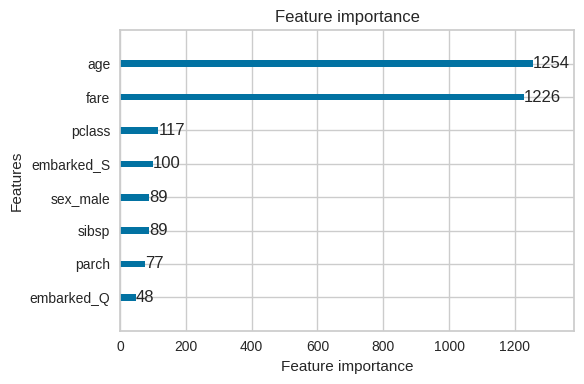

In [65]:
fig, ax = plt.subplots(figsize=(6, 4))
lgb.plot_importance(lgbm_class, ax=ax)
fig.tight_layout()
fig.savefig("images/mlpr_1008.png", dpi=300)

Podemos também criar uma árvore de decisões

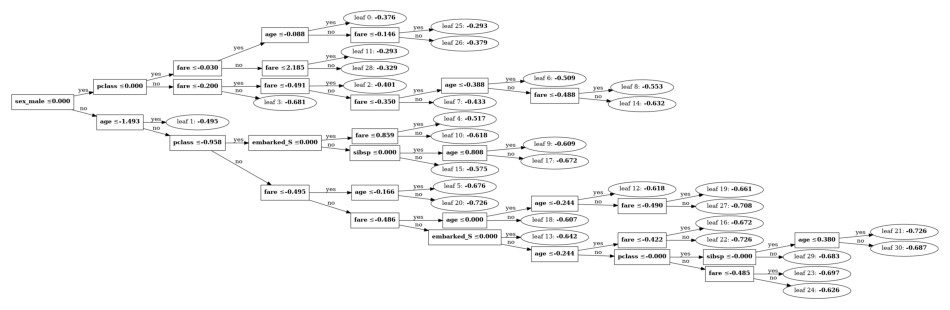

In [66]:
fig, ax = plt.subplots(figsize=(12, 10))
lgb.plot_tree(lgbm_class, tree_index=0, ax=ax)
fig.savefig("images/mlpr_1009.png", dpi=300)

### TPOT

O TPOT (https://oreil.ly/NFJvl) usa um algoritmo genérico para testar diferentes modelos e ensembles (conjuntos). Pode demorar horas ou dias para executar, pois  o algoritmo considera diversos modelos e passos de pré-processamento, assim como os hiperparâmetros desses modelos e as opções de ensembling (agrupamentos). Em uma máquina típica, uma geração dessas pode demorar cinco minutos ou mais para executar.

Esse modelo tem as seguintes propriedades:

###### Eficiência na execução

Pode demorar horas ou dias. Use '_jobs=-1' para utilizar todas as CPUs.

###### Pré-processamento dos dados

Deve remover NaN e dados de categoria.

###### Para evitar uma superadequação 

O ideal é que os resultados devem usar validação cruzada para minimizar a superadequação.

###### Interpretação dos resultados

Depende dos resultados.

Eis um modelo de uso da biblioteca:

In [67]:
#!pip install tpot

In [69]:
from tpot import TPOTClassifier

tc = TPOTClassifier(generations=2)
tc.fit(X_train, y_train)
tc.score(X_test, y_test)

/home/luciano/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py:794: FutureWarning: sklearn.metrics.SCORERS is deprecated and will be removed in v1.3. Please use sklearn.metrics.get_scorer_names to get a list of available scorers and sklearn.metrics.get_metric to get scorer.
  warnings.warn(


0.7964376590330788

In [70]:
tc.predict(X.iloc[[0]])

array([0])

In [71]:
tc.predict_proba(X.iloc[[0]])

array([[0.87436028, 0.12563972]])

###### Parâmetros da instância

-> generations=100 => Iterações a serem executadas.

-> population_size=100 => Tamanho da população para a programação genérica. Tamanhos maiores em geral têm melhor desempenho, porém exigem mais tempo e dinheiro.

-> offspring_size=None => Descendentes para cada geração. O default é 'population_size'.

-> mutation_rate=0.9 => Taxa de mutação para o algoritmo, de [0, 1]. o default é 0,9.

-> crossover_rate=.1 => Taxa de cross-over (quantos pipelines devem ser criados em uma geração). Intervalo de [0,1]. O default é 0.1.

-> scoring='accuracy' => Sistema de pontuação. Usa strings do sklearn.

-> cv=5 => Folds de validação cruzada.

-> subsample=1 => Subamostra das instâncias de treinamento. Intervalo de [0, 1].

-> n_jobs=1 => Número de CPUs a serem usadas, -1 para todos os cores (núcleos).

-> max_time_mins=None => Quantidade máxima de minutos para executar.

-> max_eval_time_mins=5 => Quantidade máxima de minutos para avaliar um único pipeline.

-> random_state=None => semente(seed) aleatória.

-> config_dict => Opções de configuração para otimização.

-> warm_start=False => Reutiliza chamadas anteriores de .fit.

-> memory=None => Pode fazer cache de pipelines 'auto' ou um path fará a persistência em um diretório.

-> use_dask=False => Usa dask.

-> periodic_checkpoint_folder=None => Path para uma pasta na qual será feita, periodicamente, a persistência do melhor pipeline.

-> early_stop=None => Para após executar essa quantidade de gerações sem que haja melhorias.

-> verbosity=0 => 0 = nenhuma, 1 = mínima, 2 = alta, 3 = total. Para um valor maior ou igual a 2, uma barra de progresso será exibida.

-> disable_update_check=False => Desativa a verificação de versão.

###### Atributos: 

-> evaluated_individuals_ => Dicionário com todos os pipelines que foram avaliados.

-> fitted_pipeline_ => Melhor pipeline.

###### Depois de executar, poderá exportar o pipeline:

In [72]:
tc.export("tpot_exported_pipeline.py")